In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

sns.color_palette("tab10")
sns.set(rc={
    "figure.dpi": 150,
    "text.usetex": True,
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "axes.labelsize": "small",
    "axes.titlesize": "small",
    "figure.titlesize": "medium",
    "axes.titlepad": 2.0,
    "xtick.major.pad": -4.0,
    #"figure.subplot.hspace": 0.0,
    "figure.constrained_layout.use": True,
})

In [15]:
def attribute_to_matrix(sequences, attribute):
    attribute_list = []
    for seq in sequences:
        attribute_list.append(seq[attribute])
    return np.array(attribute_list)

def cold_starts(init_times):
    num_activations = init_times.size
    num_cold_starts = np.sum(init_times > 0)
    return num_activations, num_cold_starts

def app_name(filename: str) -> str:
    app_name = filename[filename.find(":")+4:filename.find("_fetched_")]
    if "_rand" in filename:
        app_name += "_rand"
    return app_name

def get_index(applist: list, filename: str) -> int:
    return applist.index(app_name(filename))

In [16]:
# Number of activations vs number of cold starts.

# Configuration
dir = "final_high_load_n_1000"
#dir = "final_batched_high_load_n_400"

files = Path(f"../data/{dir}").glob('*.pkl')

for f in sorted(files):
    print(f)
    with open(f, "rb") as stream:
        data = torch.load(stream)
    num_activations, num_cold_starts = cold_starts(attribute_to_matrix(data["sequences"], "init_times"))
    #print(f"Number of activations: {num_activations}")
    #print(f"Number of cold starts: {num_cold_starts}")
    print(f"Cold start to activation ratio: {round(num_cold_starts / num_activations, 4)}")

../data/final_high_load_n_1000/injected_20210610_23:14_fanout_large_fetched_397_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01.pkl
Cold start to activation ratio: 0.3002
../data/final_high_load_n_1000/injected_20210611_00:04_parallel_large_fetched_390_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01.pkl
Cold start to activation ratio: 0.3008
../data/final_high_load_n_1000/injected_20210611_00:53_tree_large_fetched_399_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01.pkl
Cold start to activation ratio: 0.3007
../data/final_high_load_n_1000/injected_20210611_01:43_fanout_large_fetched_391_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01_rand.pkl
Cold start to activation ratio: 0.3002
../data/final_high_load_n_1000/injected_20210611_02:33_parallel_large_fetched_383_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01_rand.pkl
Cold start to activation ratio: 0.3005
../data/final_high_load_n_1000/injected_20210611_03:23_tree_large_fetched_398_n1_0_l1_0.0_u1_0.0_n2_400_l2_0.01_u2_0.01_rand.pkl
Cold start to activation ratio: 0.

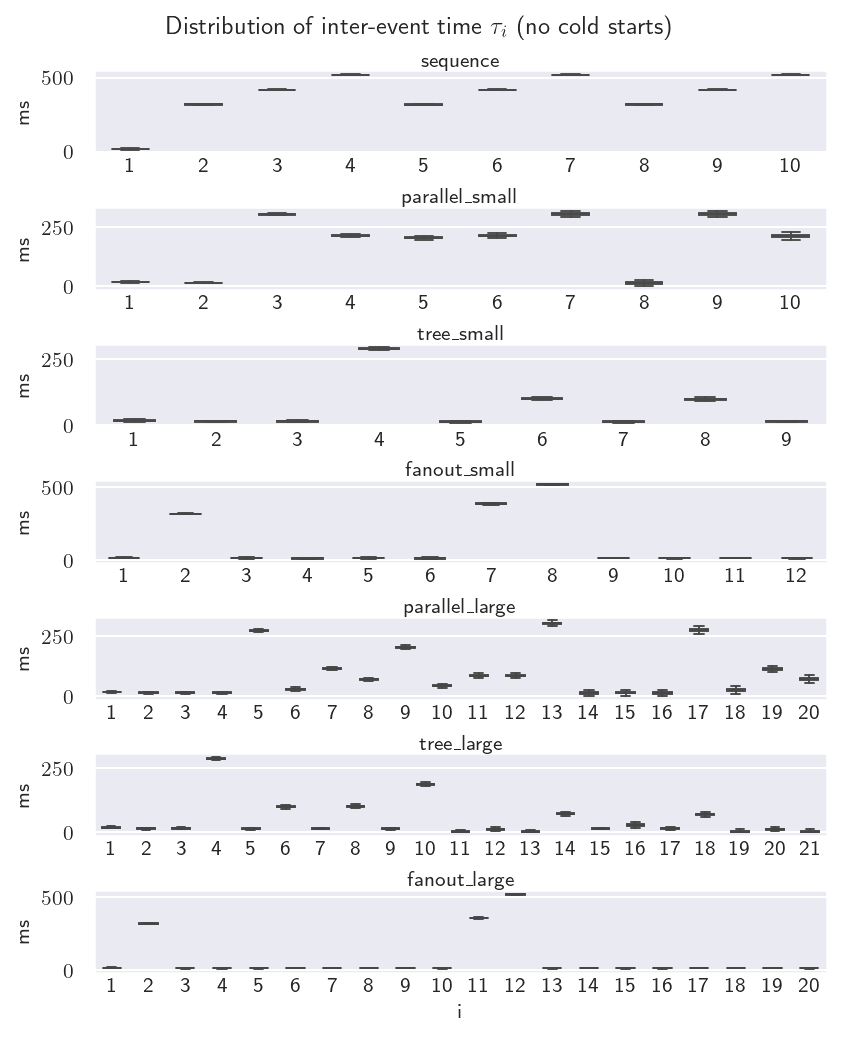

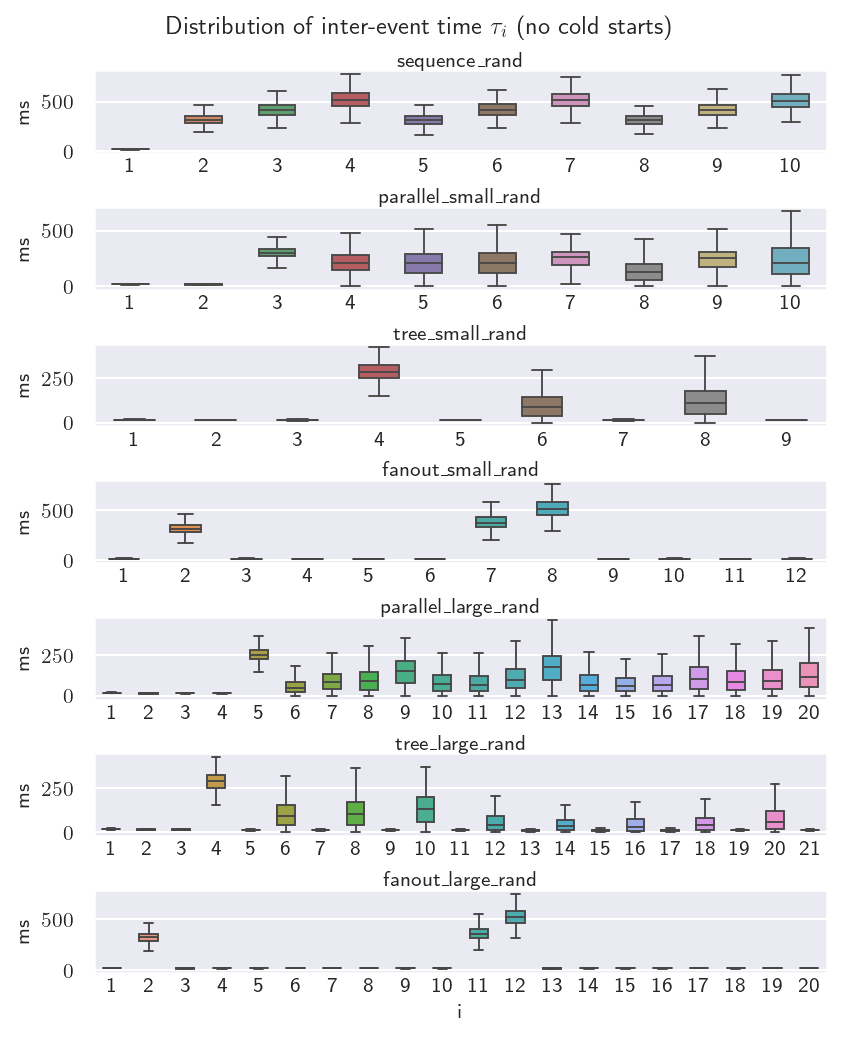

In [17]:
# Average inter-event time for each step.

# Configuration
dir = "final_low_load_n_1000"
#dir = "final_high_load_n_1000"
save = False

def boxplot(applist: list, file2data: dict, title: str, ylabel: str) -> plt.Figure:
    fig, ax = plt.subplots(len(applist), 1)
    fig.set_size_inches(5.5, 6.8)
    fig.suptitle(title)
    for filename, data in file2data.items():
        if app_name(filename) in applist:
            sns.boxplot(ax=ax[get_index(applist, filename)], data=data, width=0.5, showfliers=False, linewidth=0.9)
            ax[get_index(applist, filename)].set_title(app_name(filename).replace("_", "\_"))
            ax[get_index(applist, filename)].set_ylabel(ylabel)
            ax[get_index(applist, filename)].set_xticklabels(list(range(1, data.shape[-1] + 1)))
    ax[-1].set_xlabel("i")
    return fig

prestr = "ll_"
if "high_load" in dir: prestr = "hl_"

poststr = " (no cold starts)"
if "high_load" in dir: poststr = " (30\% cold starts)"

apps = ["sequence", "parallel_small", "tree_small", "fanout_small", "parallel_large", "tree_large", "fanout_large"]
apps_rand = ["sequence_rand", "parallel_small_rand", "tree_small_rand", "fanout_small_rand", "parallel_large_rand", "tree_large_rand", "fanout_large_rand"]

inter_dict = {}
init_dict = {}
wait_dict = {}

files = Path(f"../data/{dir}").glob('*.pkl')
for f in sorted(files):
    with open(f, "rb") as stream:
        data = torch.load(stream)
    inter_dict[str(f)] = np.diff(attribute_to_matrix(data["sequences"], "arrival_times"), axis=-1)
    init_dict[str(f)] = attribute_to_matrix(data["sequences"], "init_times")
    wait_dict[str(f)] = attribute_to_matrix(data["sequences"], "wait_times") / 1000

title = fr"Distribution of inter-event time $\tau_i${poststr}"
ylabel = "ms"
fig1 = boxplot(apps, inter_dict, title, ylabel)
if save: plt.savefig(f"data_plots/{prestr}dist_inter.pdf")
fig2 = boxplot(apps_rand, inter_dict, title, ylabel)
if save: plt.savefig(f"data_plots/{prestr}dist_inter_rand.pdf")

if "high_load" in dir:
    title = fr"Distribution of initTime $i_i${poststr}"
    ylabel = "ms"
    fig1 = boxplot(apps, init_dict, title, ylabel)
    if save: plt.savefig(f"data_plots/{prestr}dist_init.pdf")
    fig2 = boxplot(apps_rand, init_dict, title, ylabel)
    if save: plt.savefig(f"data_plots/{prestr}dist_init_rand.pdf")

    title = fr"Distribution of waitTime $w_i${poststr}"
    ylabel = "sec"
    fig1 = boxplot(apps, wait_dict, title, ylabel)
    if save: plt.savefig(f"data_plots/{prestr}dist_wait.pdf")
    fig2 = boxplot(apps_rand, wait_dict, title, ylabel)
    if save: plt.savefig(f"data_plots/{prestr}dist_wait_rand.pdf")      

/var/folders/v5/w39m_r414yn9h24tnq2qg4fm0000gn/T/ipykernel_19751/4040500377.py:67: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig_inter.tight_layout()
/var/folders/v5/w39m_r414yn9h24tnq2qg4fm0000gn/T/ipykernel_19751/4040500377.py:68: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig_init.tight_layout()
/var/folders/v5/w39m_r414yn9h24tnq2qg4fm0000gn/T/ipykernel_19751/4040500377.py:69: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig_wait.tight_layout()


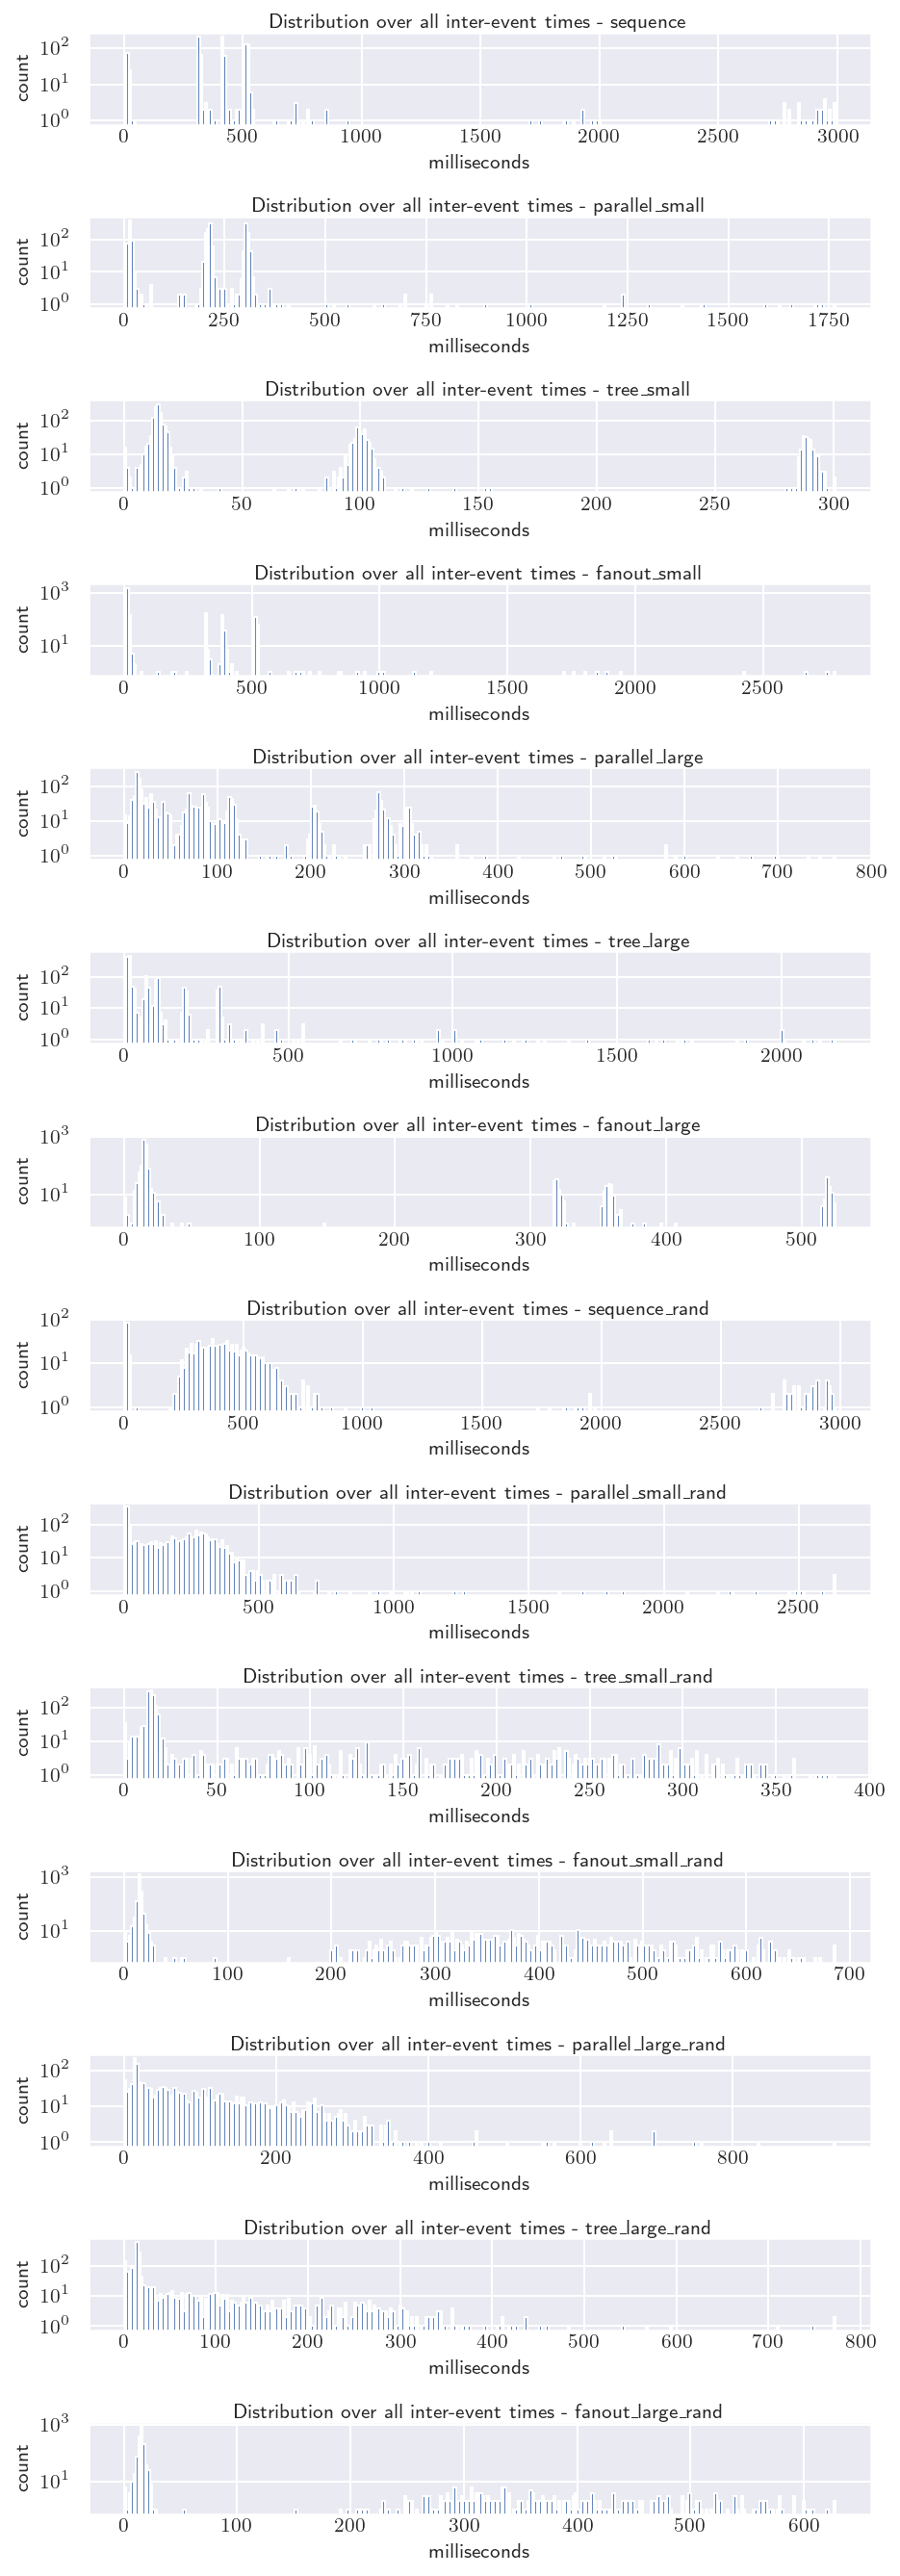

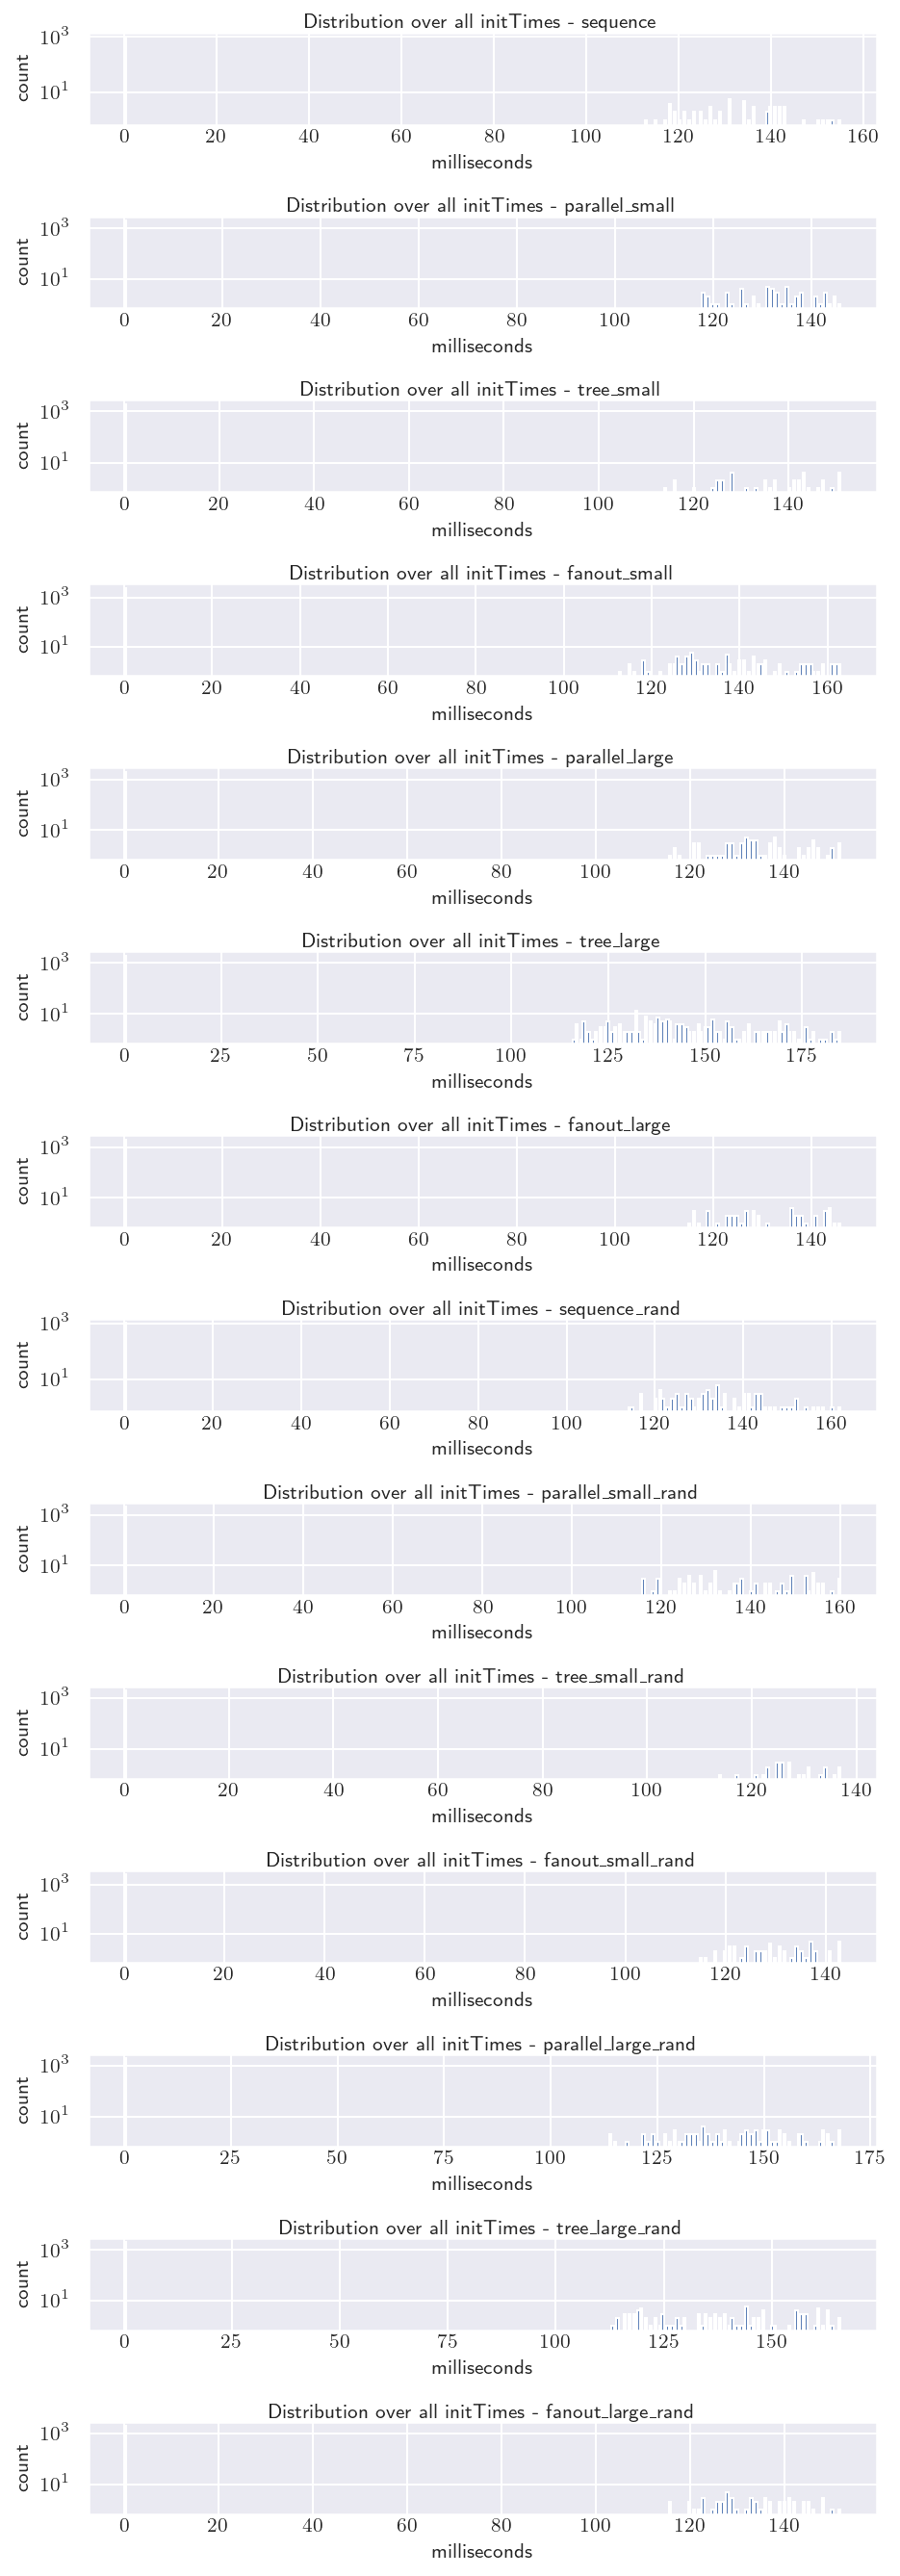

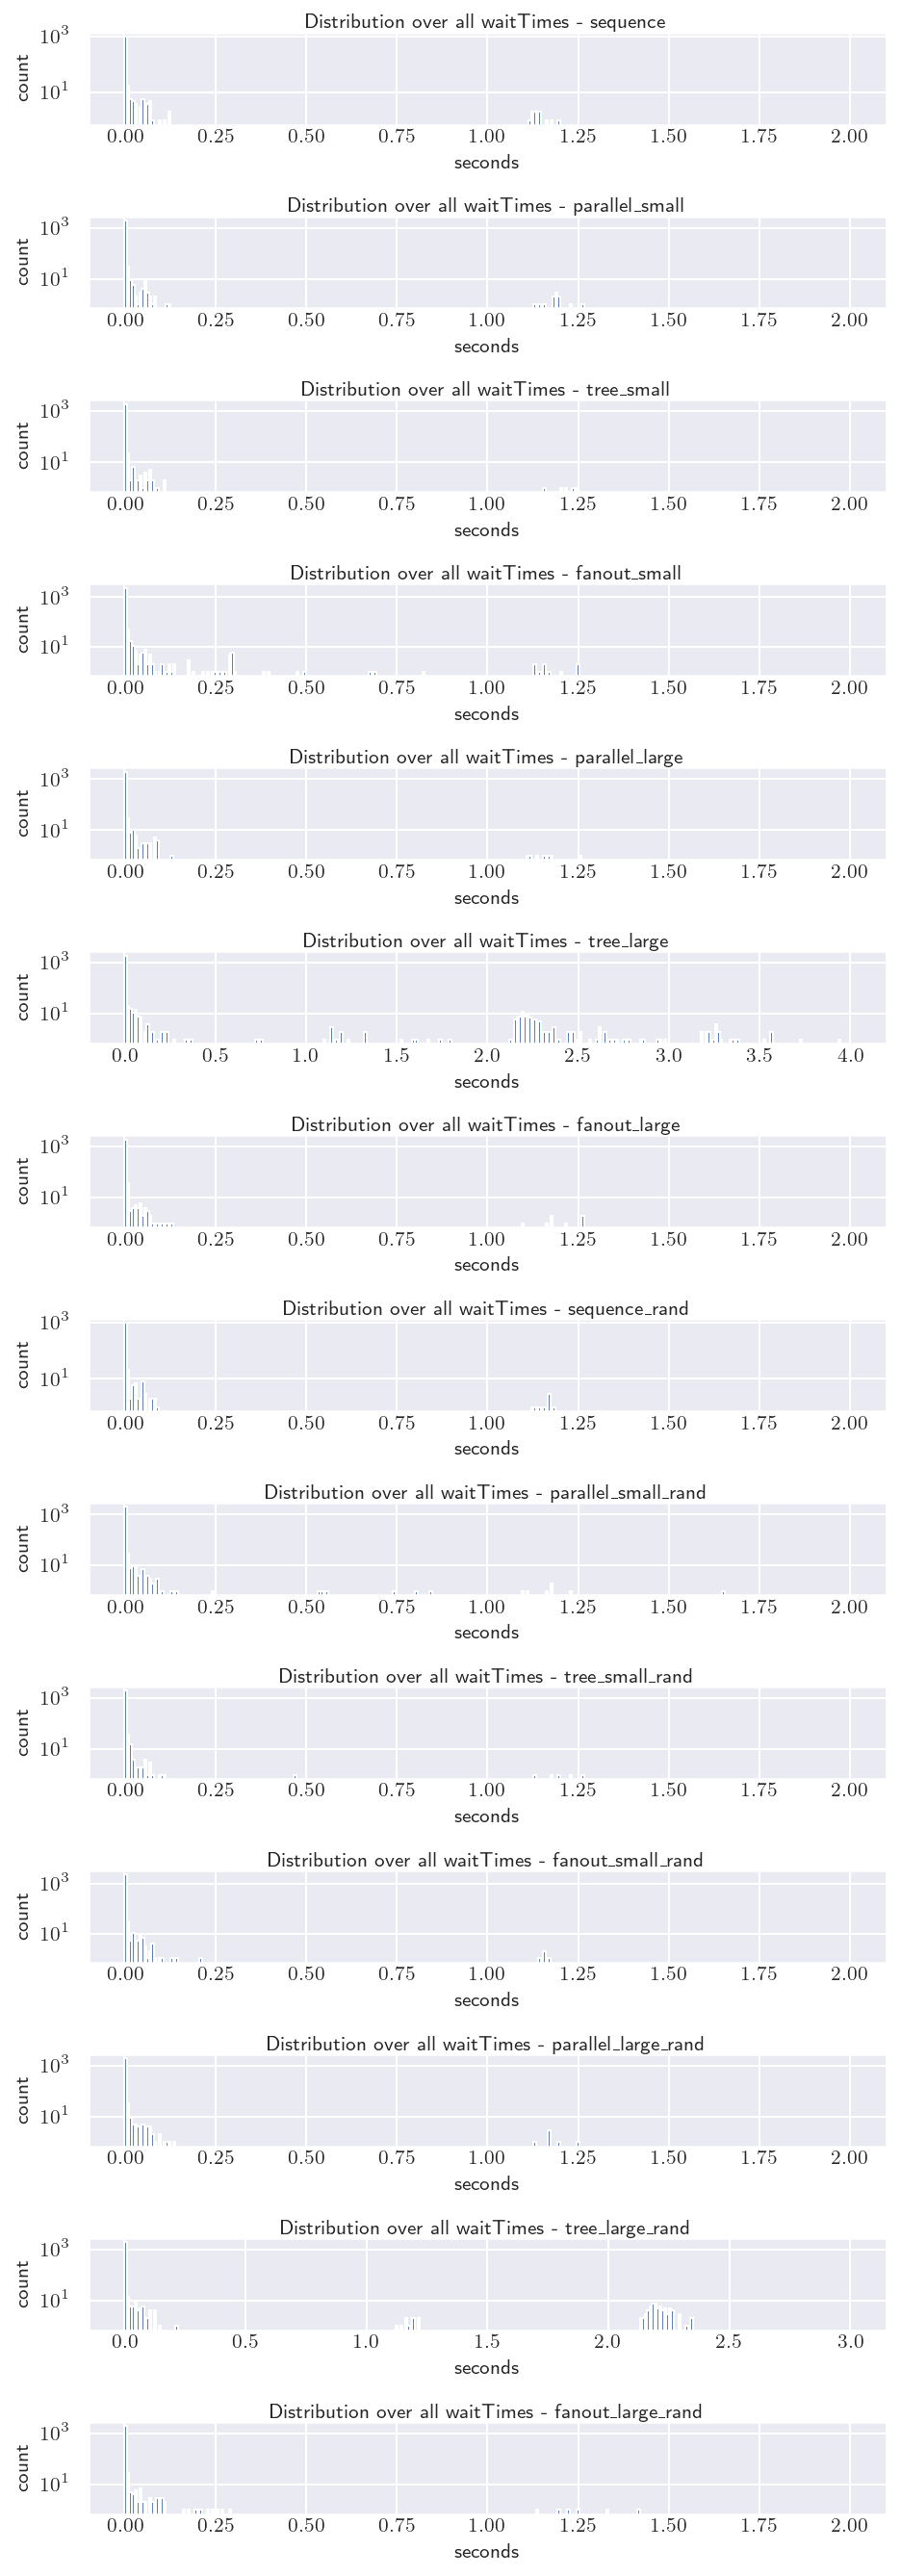

In [18]:
# Distribution of inter-event, init and wait times.

# Configuration
dir = "final_low_load_n_1000"
#dir = "final_high_load_n_1000"
#dir = "final_batched_high_load_n_400"
plot_init_times = True
plot_wait_times = True
save = False

def compose_title(filename):
    def app_name(filename):
        app_name = filename[filename.find(":")+4:filename.find("_fetched_")]
        return app_name.replace("_", "\_")
    title = app_name(filename)
    if "_rand" in filename:
        title += "\_rand"
    if "_n2_" in filename:
        title += " (30% cold starts)"
    return title

apps = ["sequence", "parallel_small", "tree_small", "fanout_small", "parallel_large", 
        "tree_large", "fanout_large", "sequence_rand", "parallel_small_rand", "tree_small_rand",
        "fanout_small_rand", "parallel_large_rand", "tree_large_rand", "fanout_large_rand"]
files = Path(f"../data/{dir}").glob('*.pkl')

fig_inter, ax_inter = plt.subplots(14, 1)
fig_inter.set_size_inches(6.4, 18)
fig_init, ax_init = plt.subplots(14, 1)
fig_init.set_size_inches(6.4, 18)
fig_wait, ax_wait = plt.subplots(14, 1)
fig_wait.set_size_inches(6.4, 18)

for i, f in enumerate(sorted(files)):
    with open(f, "rb") as stream:
        data = torch.load(stream)
    
    if "small" in str(f):  
        numb_traces = 200
    else:
        numb_traces = 100
        
    inter_event_times = np.diff(attribute_to_matrix(data["sequences"], "arrival_times"), axis=-1)[:numb_traces].reshape(-1)
    init_times = attribute_to_matrix(data["sequences"], "init_times")[:numb_traces].reshape(-1)
    wait_times = attribute_to_matrix(data["sequences"], "wait_times")[:numb_traces].reshape(-1) / 1000
    
    max_range = int(np.quantile(inter_event_times, 0.99))
    ax_inter[get_index(apps, str(f))].hist(inter_event_times, bins=300, range=(0.0, max_range), log=True)
    ax_inter[get_index(apps, str(f))].set_xlabel("milliseconds")
    ax_inter[get_index(apps, str(f))].set_ylabel("count")
    ax_inter[get_index(apps, str(f))].title.set_text(f"Distribution over all inter-event times - {compose_title(str(f))}")
    
    if plot_init_times:
        max_range = int(np.quantile(init_times, 0.99))
        ax_init[get_index(apps, str(f))].hist(init_times, bins=300, range=(0.0, max_range), log=True)
        ax_init[get_index(apps, str(f))].set_xlabel("milliseconds")
        ax_init[get_index(apps, str(f))].set_ylabel("count")
        ax_init[get_index(apps, str(f))].title.set_text(f"Distribution over all initTimes - {compose_title(str(f))}")
    
    if plot_wait_times:
        max_range = int(np.quantile(wait_times, 0.99))
        ax_wait[get_index(apps, str(f))].hist(wait_times, bins=300, range=(0.0, max_range), log=True)
        ax_wait[get_index(apps, str(f))].set_xlabel("seconds")
        ax_wait[get_index(apps, str(f))].set_ylabel("count")
        ax_wait[get_index(apps, str(f))].title.set_text(f"Distribution over all waitTimes - {compose_title(str(f))}")
    
fig_inter.tight_layout()
fig_init.tight_layout()
fig_wait.tight_layout()
    
if save:
    filename = f"{str(f)[str(f).rfind('/')+1:str(f).rfind('.pkl')]}.png"
    plt.savefig(filename)

In [19]:
# Standard deviation of inter-event, init and wait time

# Configuration
dir = "final_low_load_n_1000"

files = Path(f"../data/{dir}").glob('*.pkl')

def app_name(filename):
    app_name = filename[filename.find(":")+4:filename.find("_fetched_")]
    if "rand" in filename:
        app_name += "_rand"
    return app_name

for f in sorted(files):
    with open(f, "rb") as stream:
        data = torch.load(stream)
    inter_event_times = np.diff(attribute_to_matrix(data["sequences"], "arrival_times"), axis=-1)
    init_times = attribute_to_matrix(data["sequences"], "init_times")
    wait_times = attribute_to_matrix(data["sequences"], "wait_times") #/ 1000
    
    print(f"app={app_name(str(f))}\n"
          f"std_inter_event={np.std(inter_event_times)}\n"
          f"std_init={np.std(init_times)}\n"
          f"std_wait={np.std(wait_times)}\n")

app=fanout_large
std_inter_event=151.05177762236863
std_init=8.144257456732442
std_wait=114.77229044370371

app=parallel_large
std_inter_event=109.44044903032881
std_init=9.297179170864
std_wait=127.57963467870893

app=tree_large
std_inter_event=131.23154306078888
std_init=16.78905591489502
std_wait=291.31143757231473

app=fanout_large_rand
std_inter_event=151.65812343240964
std_init=8.883851129119272
std_wait=130.1648441444701

app=parallel_large_rand
std_inter_event=109.44652378874352
std_init=10.602357329970584
std_wait=138.1014849145728

app=tree_large_rand
std_inter_event=97.52263492725262
std_init=11.27306997866161
std_wait=179.97986456871658

app=fanout_small
std_inter_event=239.70282899756836
std_init=13.732588276619522
std_wait=234.60153714089307

app=parallel_small
std_inter_event=161.9196585169324
std_init=11.742867522581214
std_wait=153.98688379668323

app=sequence
std_inter_event=224.63991208489645
std_init=11.105719767848612
std_wait=139.50763483666051

app=tree_small
std